In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Standardization formula: z = (x - mean) / standard_deviation

class Standardiser():
    def __init__(self) -> None:
        pass

    def fit(self, X):
        self.size = X.shape[1]
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self     #returns self, which allows method chaining

    def transform(self,X):
        if X.shape[1] != self.size:
            raise Exception("Wrong array dimensions!")
        return (X-self.mean)/self.std


In [3]:
def shuffle_data(X, Y):
    data_num = np.arange(X.shape[0])
    np.random.shuffle(data_num)
    return X[data_num], Y[data_num]

def train_test_split(X, Y, test_size=0.5, shuffle=True):
    """
    Splits dataset into training and test sets.

    Parameters:
    ----------
    X : array-like
        Feature dataset.
    y : array-like
        Target values.
    test_size : float or int, default=0.5
        - If float (0 < test_size < 1), it represents the proportion of the dataset to include in the test split.
        - If int (1 <= test_size < len(y)), it represents the absolute number of test samples.
    shuffle : bool, default=True
        If True, shuffles data before splitting.

    Returns:
    -------
    X_train, X_test, y_train, y_test : array-like
        Split feature and target sets for training and testing."""

    if shuffle:
        X, Y = shuffle_data(X, Y)
    if test_size <1 :
        train_ratio = len(Y) - int(len(Y) *test_size)
        X_train, X_test = X[:train_ratio], X[train_ratio:]
        Y_train, Y_test = Y[:train_ratio], Y[train_ratio:]
        return X_train, X_test, Y_train, Y_test
    elif test_size in range(1,len(Y)):
        X_train, X_test = X[test_size:], X[:test_size]
        Y_train, Y_test = Y[test_size:], Y[:test_size]
        return X_train, X_test, Y_train, Y_test
    

Class **LWLR()** used for locally weighted linear regression.

In [4]:
class LWLR():
    def __init__(self,tau=1):
        self.tau = tau


    def fit(self,X, Y):
        self.dim = X.ndim
        self.X = self._add_ones(X)
        self.X_T = self.X.T
        self.Y = Y
        # self.lambda_reg = 0.5 #If we add regularization term


    def predict(self, P):
        P = self._add_ones(P)
        out = []
        for p in P:
            # Vectorized calculation of weights
            W = np.exp(-np.sum((self.X - p) ** 2, axis=1) / (2 * self.tau ** 2))    #Do the sume because we have many predictors
            W_diag = np.diag(W)
            # Calculate theta using vectorized operations
            XT_W_X = self.X_T @ W_diag @ self.X
            # XT_W_X += self.lambda_reg * np.eye(XT_W_X.shape[0])  #We can ddd regularization term
            XT_W_Y = self.X_T @ W_diag @ self.Y
            theta = np.linalg.solve(XT_W_X, XT_W_Y) #Solving XT_W_X @ theta = XT_W_Y is faster and more stable than calculating np.linalg.inv(XT_W_X) @ XT_W_Y
            # Make prediction
            out.append((theta @ p).squeeze())
        return np.array(out)


    def change_tau(self,tau):
        self.tau = tau


    def _add_ones(self, X):
        if type(X) != np.ndarray:
            X = np.array(X)
        return np.concatenate((np.ones((len(X),1)), X.reshape(len(X),-1)), axis=1)

Functions used for cross-validation.

In [5]:
def evaluate_model(Y_true, Y_pred, metric="rmse", normalize=True):
    """
    Evaluate the model based on the specified metric.

    Parameters:
    - Y_true (array-like): True labels.
    - Y_pred (array-like): Predicted labels.
    - metric (str): The metric to use for evaluation. Options are "class_accuracy" and "rmse".
    - normalize (bool): If True, returns accuracy as a fraction; otherwise, returns the count.

    Returns:
    - float: Calculated score based on the specified metric.
    """
    
    Y_true, Y_pred = np.ravel(Y_true), np.ravel(Y_pred)  # Flatten to 1D

    if Y_true.shape != Y_pred.shape:
        raise ValueError("Y_true and Y_pred must have the same number of elements.")
    
    if metric == "class_accuracy":
        score = np.mean(Y_true == Y_pred) if normalize else np.sum(Y_true == Y_pred)
    elif metric == "rmse":
        score = np.sqrt((np.square(Y_pred - Y_true)).mean())
    else:
        raise ValueError("Invalid metric. Choose either 'accuracy' or 'rmse'.")
    return score


def cross_val_split(X, Y, num_folds):
    fold_size = len(X)//num_folds
    X_splits, Y_splits = [], []

    for i in range(num_folds):
        start_index = i * fold_size
        if i == num_folds-1:
            X_splits.append(X[start_index:])
            Y_splits.append(Y[start_index:])
        else:
            X_splits.append(X[start_index:start_index + fold_size])
            Y_splits.append(Y[start_index:start_index + fold_size])
    return X_splits, Y_splits


def cross_val_score(model, X, Y, num_folds=5, scoring='rmse'):
    X_splits, Y_splits = cross_val_split(X, Y, num_folds)
    errors_train = []  
    errors_valid = []

    for i in range(num_folds):
        X_train_data = np.concatenate([fold for a, fold in enumerate(X_splits) if a != i])
        Y_train_data = np.concatenate([fold for a, fold in enumerate(Y_splits) if a != i])
        X_valid_data = X_splits[i]
        Y_valid_data = Y_splits[i]

        model.fit(X_train_data, Y_train_data)
        prediction_train = model.predict(X_train_data)
        prediction_valid = model.predict(X_valid_data)
        # Calculating mean square error
        train = evaluate_model(Y_train_data, prediction_train, metric=scoring)
        valid = evaluate_model(Y_valid_data, prediction_valid, metric=scoring)
        errors_train.append(train)
        errors_valid.append(valid) 
    return np.array(errors_train), np.array(errors_valid)


def validation_curve(model, X, Y, param_range, num_folds=5, scoring='rmse'):
    """
    Generate training and validation errors for a model across a specified range of parameter values.

    Parameters:
    - model (class): The model class (not instance) to be evaluated. The model class should support a method
                     `change_tau` to adjust the parameter being tested (e.g., learning rate, regularization).
    - X (array-like): Input features.
    - Y (array-like): Target labels.
    - param_range (iterable): A range of parameter values to evaluate (e.g., different values for 'tau').
    - num_folds (int, optional): Number of folds for cross-validation. Default is 5.
    - scoring (str, optional): The metric used to evaluate model performance. Options are "class_accuracy" 
                               and "rmse" (root mean square error). Default is "rmse".

    Returns:
    - tuple: Two lists containing arrays of training and validation errors for each parameter value in `param_range`.
             Each entry in the lists corresponds to the error results across the cross-validation folds for 
             a specific parameter value.
    
    The function evaluates the model's performance over a series of parameter values (e.g., regularization values or
    learning rates) by performing cross-validation for each value. The model's `change_tau` method is used to adjust
    the tested parameter. Training and validation errors for each parameter value are stored, allowing for a comparison
    of model performance across the parameter range.
    """
    
    range_error_train, range_error_valid = [], []
    model_use = model()
    for i in param_range:
        model_use.change_tau(i)
        errors_train, errors_valid = cross_val_score(model_use, X, Y, num_folds, scoring)
        range_error_train.append(errors_train)
        range_error_valid.append(errors_valid)
    return range_error_train, range_error_valid

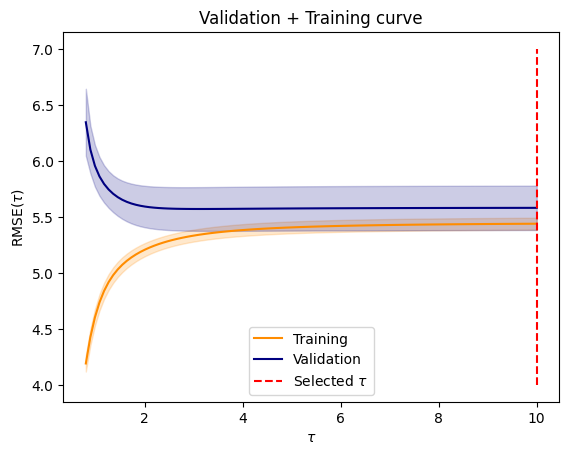

In [6]:
#Read the data
dile_name = 'data-reg.csv'
raw_data = pd.read_csv(dile_name, header=None).to_numpy()
X = raw_data[:,:5]
Y = raw_data[:,-1]

#Split data to train test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=True)

#Standardisation of the data 
scaler = Standardiser().fit(X_train)
try:
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
except Exception as e:
  print(e)


#Choosing optimal hyperparameters
tau_range = np.linspace(0.8,10,num=100)
range_errors_train, range_errors_valid = validation_curve(LWLR, X_train_scaled, Y_train, tau_range, num_folds=5, scoring='rmse')

# Each column contains the score for one "fold" of cross-validation.
# Each row corresponds to a specific polynomial degree.
# We use the folds to calculate the mean and 
# standard deviation of the score for each individual polynomial degree.
train_scores_mean = np.mean(range_errors_train, axis=1)
train_scores_std = np.std(range_errors_train, axis=1)
valid_scores_mean = np.mean(range_errors_valid, axis=1)
valid_scores_std = np.std(range_errors_valid, axis=1)

plt.title("Validation + Training curve")
plt.xlabel(r"$\tau$")
plt.ylabel(r"RMSE($\tau$)")
lw = 2
plt.plot(tau_range, train_scores_mean, label="Training", color="darkorange")
plt.fill_between(tau_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color="darkorange")
plt.plot(tau_range, valid_scores_mean, label="Validation", color="navy")
plt.fill_between(tau_range, valid_scores_mean - valid_scores_std,
                valid_scores_mean + valid_scores_std, alpha=0.2,
                color="navy")
plt.plot([10, 10], [4, 7], 'r--', label = r"Selected $\tau$")
plt.legend(loc="best")
plt.show()

Calculating error for optimal model:

Since we observe that for small values of tau, the error on the training set is the lowest, while it is the highest on the validation set, we conclude that overfitting has occurred here. Essentially, this makes sense because each point is given a very small neighborhood in which other points have an influence, causing the model to learn each point individually without generalizing.

For larger values of tau (tested up to tau = 100), we see a saturation effect, meaning that beyond a certain value, the specific choice of tau is less critical. I selected a tau of 10 as the best value based on the provided graph, balancing the error on the training and validation sets.

In [7]:
tau_opt = 10
lwlr = LWLR(tau_opt)
lwlr.fit(X_train_scaled,Y_train)

# Generating prediction
prediction_train = lwlr.predict(X_train_scaled)
prediction_test = lwlr.predict(X_test_scaled)

# Calculating mean square error
mse_train = evaluate_model(Y_train, prediction_train, metric='rmse')
mse_test = evaluate_model(Y_test, prediction_test, metric='rmse')

print("Mean square error on training data:")
print("{:.2f}".format(mse_train))
print("Mean square error on test data:")
print("{:.2f}".format(mse_test))

Mean square error on training data:
5.45
Mean square error on test data:
6.01
